# Глубокая нейронная сеть для классификации изображений: применение

Когда вы закончите это, вы выполните последнее задание по ручному программированию нейронных сетей!

Вы будете использовать функции, которые вы реализовали в предыдущем задании, для построения глубокой сети и применять ее для классификации кошек и не кошек. Надеемся, вы увидите улучшение точности по сравнению с предыдущей реализацией логистической регрессии.

**После этого задания вы сможете:**  
- Создадите и примените глубокую нейронную сеть для контролируемого обучения.

Давайте начнем!

## 1 - Пакеты

Давайте сначала импортируем все пакеты, которые вам понадобятся во время этого задания.
- [numpy](www.numpy.org) — фундаментальный пакет для научных вычислений на Python.
- [matplotlib](http://matplotlib.org) — библиотека для построения графиков на Python.
- [h5py](http://www.h5py.org) — это общий пакет для взаимодействия с набором данных, хранящимся в файле H5.
- [PIL](http://www.pythonware.com/products/pil/) и [scipy](https://www.scipy.org/) используются здесь для проверки вашей модели с вашим собственным изображением в конце.
- dnn_app_utils предоставляет функции, реализованные в задании «Создание глубокой нейронной сети: шаг за шагом» для этого блокнота.
- np.random.seed(1) используется для обеспечения согласованности всех вызовов случайных функций. Это поможет нам оценить вашу работу.

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

## 2 - Набор данных

Вы будете использовать набор данных «Кошка/не-кошка».

**Постановка задачи**: Вам предоставлен набор данных ("data.h5"), содержащий:
     - обучающий набор изображений m_train, помеченных как кошки (1) или не кошки (0)
     - тестовый набор изображений m_test, помеченных как кошки и не кошки
     - каждое изображение имеет форму (num_px, num_px, 3), где 3 соответствует 3 каналам (RGB).

Давайте познакомимся с набором данных поближе. Загрузите данные, запустив ячейку ниже.

In [2]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

Следующий код покажет вам изображение из набора данных. Не стесняйтесь менять индекс и повторно запускать ячейку несколько раз, чтобы увидеть другие изображения.

y = 1. It's a cat picture.


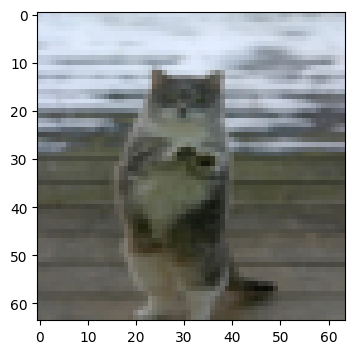

In [3]:
# Example of a picture
index = 170
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [4]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


Как обычно, вы изменяете и стандартизируете изображения перед отправкой их в нейронную сеть. Код указан в ячейке ниже.

<img src="images/imvectorkiank.png" style="width:450px;height:300px;">

<caption><center> <u>Figure 1</u>: Конвертация картинки в вектор. <br> </center></caption>

In [5]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


$12 288$ равны $64 \times 64 \times 3$, что соответствует размеру одного вектора измененного изображения.

## 3 - Архитектура вашей модели

Теперь, когда вы знакомы с набором данных, пришло время построить глубокую нейронную сеть, чтобы отличать изображения кошек от изображений, не относящихся к кошкам.

Вы построите две разные модели:
- Двухслойная нейронная сеть
- Глубокая нейронная сеть из L слоёв.

Затем вы сравните производительность этих моделей, а также опробуете разные значения $L$.

Давайте посмотрим на две архитектуры.

### 3.1 - 2-слойная нейронная сеть

<img src="images/2layerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Рис. 2</u>: двухслойная нейронная сеть. <br> Модель можно резюмировать следующим образом: ***ВХОД -> ЛИНЕЙНЫЙ -> RELU -> ЛИНЕЙНЫЙ -> СИГМОИДА -> ВЫХОД***. </center></caption>

<u>Подробная архитектура рисунка 2</u>:
- Входные данные представляют собой изображение (64, 64, 3), преобразованное в вектор размера $(12288, 1)$.
- Соответствующий вектор: $[x_0,x_1,...,x_{12287}]^T$ умножается на весовую матрицу $W^{[1]}$ размера $(n^{[1]} , 12288)$.
- Затем вы добавляете смещение и берете от него relu, чтобы получить следующий вектор: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1 }^{[1]}]^T$.
- Затем вы повторяете тот же процесс.
- Вы умножаете полученный вектор на $W^{[2]}$ и добавляете смещение.
- Наконец, вы берете сигмоиду от результата. Если оно больше 0.5, вы классифицируете его как кошку.

### 3.2 - Глубокая L-слойная нейронная сеть

Трудно представить глубокую L-слойную нейронную сеть с помощью приведенного выше представления. Однако вот упрощенное представление сети:

<img src="images/LlayerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Рис. 3</u>: L-слойная нейронная сеть. <br> Модель можно резюмировать следующим образом: ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID***</center></caption>

<u>Подробная архитектура рисунка 3</u>:
- Входные данные представляют собой изображение (64, 64, 3), преобразованное в вектор размера (12288, 1).
- Соответствующий вектор: $[x_0,x_1,...,x_{12287}]^T$ умножается на весовую матрицу $W^{[1]}$, а затем добавляется смещение $b^{[ 1]}$. Эта часть является линейной.
- Далее берёте relu. Этот процесс может повторяться несколько раз для каждого $(W^{[l]}, b^{[l]})$ в зависимости от архитектуры модели.
- Наконец, вы берете сигмоиду от конечного линейного преобразования. Если оно больше 0.5, вы классифицируете его как кошку.

### 3.3 - Общая методология

Как обычно, для построения модели вы будете следовать методологии глубокого обучения:
 1. Инициализация параметров/Определение гиперпараметров.
 2. Цикл по num_iterations:
     - а. Прямое распространение
     - б. Вычислить функцию стоимости
     - в. Обратное распространение
     - д. Обновить параметры (с использованием параметров и оценок из резервной копии)
 4. Использование нейронной сети с обученными параметрами для предсказания.

Давайте реализуем эти две модели!

## 4 - Двухслойная нейронная сеть

**Задание**: используйте вспомогательные функции, которые вы реализовали в предыдущем задании, для построения двухслойной нейронной сети следующей структуры: *LINEAR -> RELU -> LINEAR -> SIGMOID*. Функции, которые вам могут понадобиться, и их входные данные:
```python
def initialize_parameters(n_x, n_h, n_y):
    ...
    return parameters 
def linear_activation_forward(A_prev, W, b, activation):
    ...
    return A, cache
def compute_cost(AL, Y):
    ...
    return cost
def linear_activation_backward(dA, cache, activation):
    ...
    return dA_prev, dW, db
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [6]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [7]:
# GRADED FUNCTION: two_layer_model

def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    ### START CODE HERE ### (≈ 1 line of code)
    parameters = initialize_parameters(n_x, n_h, n_y)
    ### END CODE HERE ###
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        ### START CODE HERE ### (≈ 2 lines of code)
        A1, cache1 = linear_activation_forward(X, W1, b1, 'relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, 'sigmoid')
        ### END CODE HERE ###
        
        # Compute cost
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(A2, Y)
        ### END CODE HERE ###
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        ### START CODE HERE ### (≈ 2 lines of code)
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, 'sigmoid')
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, 'relu')
        ### END CODE HERE ###
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        ### START CODE HERE ### (approx. 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Запустите ячейку ниже, чтобы обучить свои параметры. Посмотрите, работает ли ваша модель. Ошибка должна снизиться. Выполнение 2500 итераций может занять до 5 минут. Проверьте, соответствует ли «Ошибка после итерации 0» ожидаемому результату ниже, если нет, щелкните квадрат (⬛) на верхней панели блокнота, чтобы остановить ячейку и попытаться найти ошибку в коде.

Cost after iteration 0: 0.693049735659989
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912677
Cost after iteration 300: 0.6015024920354664
Cost after iteration 400: 0.5601966311605747
Cost after iteration 500: 0.5158304772764729
Cost after iteration 600: 0.4754901313943325
Cost after iteration 700: 0.43391631512257495
Cost after iteration 800: 0.4007977536203887
Cost after iteration 900: 0.35807050113237965
Cost after iteration 1000: 0.33942815383664127
Cost after iteration 1100: 0.3052753636196265
Cost after iteration 1200: 0.2749137728213016
Cost after iteration 1300: 0.24681768210614846
Cost after iteration 1400: 0.19850735037466102
Cost after iteration 1500: 0.17448318112556632
Cost after iteration 1600: 0.17080762978096284
Cost after iteration 1700: 0.11306524562164731
Cost after iteration 1800: 0.09629426845937153
Cost after iteration 1900: 0.08342617959726865
Cost after iteration 2000: 0.07439078704319087
Cost after iteration 2100: 0.0663074

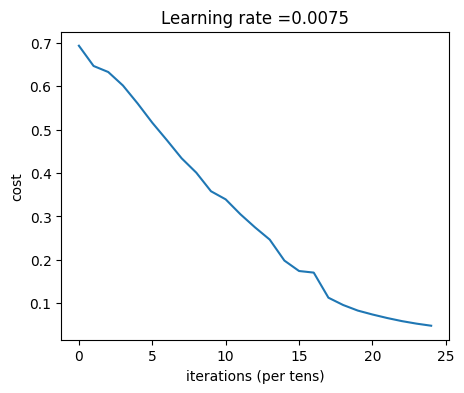

In [8]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

**Ожидаемый вывод**:
<table> 
    <tr>
        <td> **Cost after iteration 0**</td>
        <td> 0.6930497356599888 </td>
    </tr>
    <tr>
        <td> **Cost after iteration 100**</td>
        <td> 0.6464320953428849 </td>
    </tr>
    <tr>
        <td> **...**</td>
        <td> ... </td>
    </tr>
    <tr>
        <td> **Cost after iteration 2400**</td>
        <td> 0.048554785628770206 </td>
    </tr>
</table>

Хорошо, что вы создали векторизованную реализацию! В противном случае обучение могло бы занять в 10 раз больше времени.

Теперь вы можете использовать обученные параметры для классификации изображений из набора данных. Чтобы увидеть свои прогнозы по обучающим и тестовым наборам, запустите ячейку ниже.

In [9]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


**Ожидаемый вывод**:
<table> 
    <tr>
        <td> **Accuracy**</td>
        <td> 1.0 </td>
    </tr>
</table>

In [10]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.72


**Ожидаемый вывод**:

<table> 
    <tr>
        <td> **Accuracy**</td>
        <td> 0.72 </td>
    </tr>
</table>

**Примечание**. Вы можете заметить, что выполнение модели за меньшее количество итераций (скажем, 1500) обеспечивает более высокую точность на тестовом наборе. Это называется «ранняя остановка», и об этом мы поговорим в следующем курсе. Ранняя остановка – это способ предотвратить переобучение.

Поздравляем! Кажется, что ваша двухслойная нейронная сеть имеет лучшую производительность (72%), чем реализация логистической регрессии (70%). Давайте посмотрим, сможете ли вы добиться еще большего с помощью модели из $L$ слоев.

## 5 - L-слойная нейронная сеть

**Задание**: используйте вспомогательные функции, которые вы реализовали ранее, чтобы построить $L$-слойную нейронную сеть со следующей структурой: *[LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID*. Функции, которые вам могут понадобиться, и их входные данные:
```python
def initialize_parameters_deep(layers_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [11]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

In [12]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        AL, caches = L_model_forward(X, parameters)
        ### END CODE HERE ###
        
        # Compute cost.
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(AL, Y)
        ### END CODE HERE ###
    
        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        grads = L_model_backward(AL, Y, caches)
        ### END CODE HERE ###
 
        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Теперь вы обучите модель 4-слойной нейронной сети.

Запустите ячейку ниже, чтобы обучить свою модель. Ошибка обучения должна уменьшаться на каждой итерации. Выполнение 2500 итераций может занять до 5 минут. Проверьте, соответствует ли «Ошибка обучения после итерации 0» ожидаемому результату ниже, если нет, щелкните квадрат (⬛) на верхней панели блокнота, чтобы остановить ячейку и попытаться найти ошибку в коде.

In [13]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263


**Ожидаемый вывод**:
<table> 
    <tr>
        <td> **Cost after iteration 0**</td>
        <td> 0.771749 </td>
    </tr>
    <tr>
        <td> **Cost after iteration 100**</td>
        <td> 0.672053 </td>
    </tr>
    <tr>
        <td> **...**</td>
        <td> ... </td>
    </tr>
    <tr>
        <td> **Cost after iteration 2400**</td>
        <td> 0.092878 </td>
    </tr>
</table>

In [ ]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9856459330143539


<table>
    <tr>
    <td>
    **Train Accuracy**
    </td>
    <td>
    0.985645933014
    </td>
    </tr>
</table>

In [ ]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8


**Ожидаемый вывод**:

<table> 
    <tr>
        <td> **Test Accuracy**</td>
        <td> 0.8 </td>
    </tr>
</table>

Поздравляю! Кажется, что ваша 4-слойная нейронная сеть имеет лучшую производительность (80%), чем ваша 2-слойная нейронная сеть (72%) на том же тестовом наборе.

Это хорошая производительность для данной задачи. Хорошая работа!

Однако вы знаете, как получить еще более высокую точность - систематически ища лучшие гиперпараметры: learning_rate, Layers_dims, num_iterations и другие, о которых вы также узнаете в следующих уроках.

## 6 Анализ результатов

Для начала давайте взглянем на некоторые изображения, которые модель из L слоёв пометила неправильно. Это покажет несколько неправильно маркированных изображений.

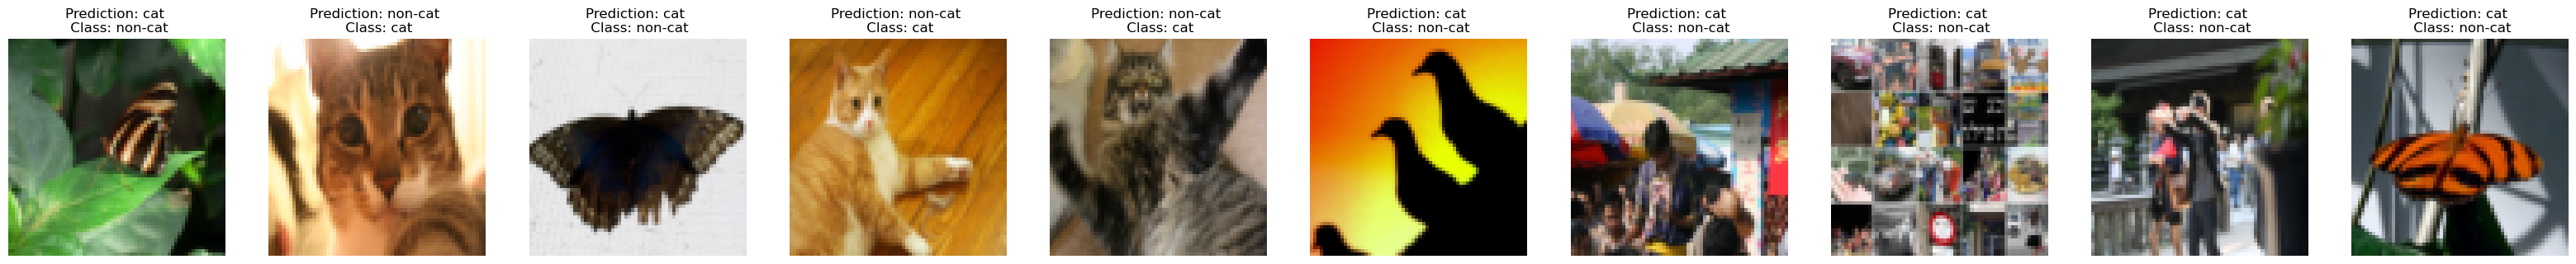

In [ ]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

**Несколько типов изображений, на которых модель обычно плохо работает:**  
- Тело кошки в необычном положении
- Кот появляется на фоне аналогичного цвета
- Необычный окрас и вид кошек
- Угол камеры
- Яркость изображения
- Изменение масштаба (на изображении кот очень большой или маленький)

## 7 Проверьте свое изображение ##

Поздравляю с завершением этого задания. Вы можете использовать собственное изображение и увидеть результат работы вашей модели. Для этого:
 1. Нажмите «Файл» в верхней панели этого блокнота, затем нажмите «Открыть».
 2. Добавьте свое изображение в каталог этого блокнота Jupyter в папке «images».
 3. Измените имя вашего изображения в следующем коде.
 4. Запустите код и проверьте правильность алгоритма (1 = кот, 0 = не кот)!

In [ ]:
from PIL import Image
## START CODE HERE ##
my_image = "кот.jpg" # change this to the name of your image file 
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)
## END CODE HERE ##

fname = "images/" + my_image
image = Image.open(my_image).resize((num_px, num_px))
my_image = np.asarray(image).flatten()
my_image = my_image/255.
my_predicted_image = predict(my_image, my_label_y, parameters)

plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

IndexError: tuple index out of range

**Использованная литература**:  

- для автоперезагрузки внешнего модуля: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython